# Introduction
In this Project, I will be using [**Breast Cancer Wisconsin (Diagnostic) Data Set**](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) dataset to classify the data using Multilayer Perceptron. I used the [**MLPClassifier**](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) from **scikit-learn** to build the model to classify the data. 

For this project we will be using functionality of [Numpy](https://numpy.org/), and [Matplotlib](https://matplotlib.org/).

*  Before we start using, make sure you have installed all those packages in your local jupyter instance.(**pip install -U scikit-learn**)
*  use **pip install scikit-optimize** (link to it can be found [here](https://pypi.org/project/scikit-optimize/#:~:text=Scikit-Optimize%2C%20or%20skopt%2C%20is%20a%20simple%20and%20efficient,built%20on%20top%20of%20NumPy%2C%20SciPy%20and%20Scikit-Learn.)) to install scikit optimizer for Bayesian optimization or try using **pip install skopt**.
*  Make sure to download the [**data.csv**](https://drive.google.com/drive/folders/1DrVnarhz2TynTg4VOqRELAv4yg-hR7P5?usp=share_link) from here before executing the following code.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.exceptions import ConvergenceWarning

import matplotlib.pyplot as plt

## Data
*  Make sure to download using link given above into your local directory before you start executing.
*  Remove the features that do not provide useful information for classification of data (**features - id, Unnamed: 32**)
*  Here we are data classification into two classes **M:1** and **B:0**.

In [2]:
data = pd.read_csv('data.csv')
data = data.drop('Unnamed: 32', axis = 1)
data = data.drop('id', axis = 1)
data['diagnosis'] = data['diagnosis'].map({'M': 1,'B': 0})
data['diagnosis'].value_counts()
data.tail(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
559,0,11.51,23.93,74.52,403.5,0.09261,0.10210,0.11120,0.04105,0.1388,...,12.480,37.16,82.28,474.2,0.12980,0.25170,0.3630,0.09653,0.2112,0.08732
560,0,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,...,15.300,33.17,100.20,706.7,0.12410,0.22640,0.1326,0.10480,0.2250,0.08321
561,0,11.20,29.37,70.67,386.0,0.07449,0.03558,0.00000,0.00000,0.1060,...,11.920,38.30,75.19,439.6,0.09267,0.05494,0.0000,0.00000,0.1566,0.05905
562,1,15.22,30.62,103.40,716.9,0.10480,0.20870,0.25500,0.09429,0.2128,...,17.520,42.79,128.70,915.0,0.14170,0.79170,1.1700,0.23560,0.4089,0.14090
563,1,20.92,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.14740,0.2149,...,24.290,29.41,179.10,1819.0,0.14070,0.41860,0.6599,0.25420,0.2929,0.09873
564,1,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.22160,0.2060,0.07115
565,1,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.16280,0.2572,0.06637
566,1,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.14180,0.2218,0.07820
567,1,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.26500,0.4087,0.12400
568,0,7.76,24.54,47.92,181.0,0.05263,0.04362,0.00000,0.00000,0.1587,...,9.456,30.37,59.16,268.6,0.08996,0.06444,0.0000,0.00000,0.2871,0.07039


In [3]:
X = data.drop('diagnosis', axis = 1).values
y = data['diagnosis'].values

In [4]:
# Normalizing data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## SVD visualization
Here I used the SVD in [numpy](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html) to get eigenvalues and used plot to check for significant eigenvalues. After find the significant eigenvalues I used [TruncaresSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) to do low rank SVD for data **X**

In [5]:
# Compute the SVD
U, s, Vt = np.linalg.svd(X) 

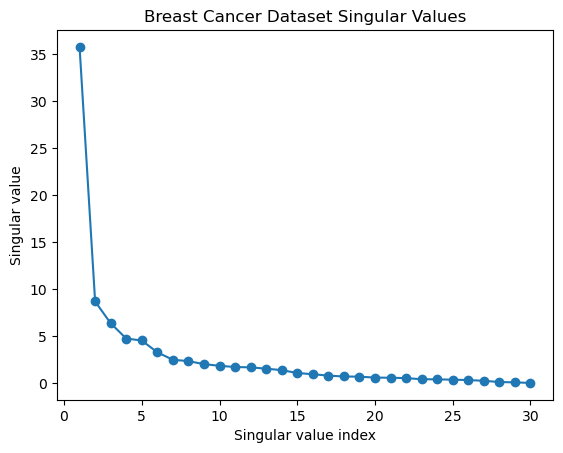

In [6]:
# Plot the singular values
fig, ax = plt.subplots()
ax.plot(range(1, len(s)+1, 1), s, 'o-')
ax.set_xlabel('Singular value index')
ax.set_ylabel('Singular value')
ax.set_title('Breast Cancer Dataset Singular Values')
plt.show()

In [7]:
svd = TruncatedSVD(n_components = 10, random_state=42)
X_svd = svd.fit_transform(X)
print(X_svd.shape)

(569, 10)


## Split the dataset
I have used [test_train_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the data into test and train data.

In [8]:
# Split data as train and test using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=128)

## Implementation of MLP_grid
I have used [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from scikit-learn to implement the grid search on hyperparameters of the [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to get best hyperparameters that give best accuracy on the data.

In [9]:
def MLP_grid(X_train, X_test, y_train, y_test, X, y):
    # MLP classifier
    mlp = MLPClassifier(max_iter = 128, early_stopping = True, random_state = 2, 
                        validation_fraction=0.2, n_iter_no_change=10)
    # Define the hyperparameters to search over
    param_grid = {
    'hidden_layer_sizes': [(32, ), (16, ), (8, )],
    'alpha': [0.001, 0.001, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'batch_size': [8, 16, 32, 64],
    'activation': ['relu', 'tanh', 'logistic', 'identity'],
    'solver': ['adam', 'sgd'],
    }
    
    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1,scoring='accuracy')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        grid_search.fit(X_train, y_train)
    
    # Print the best hyperparameters and their score
    print("Best hyperparameters:", grid_search.best_params_)
    print('Test accuracy for the best model:', grid_search.score(X_test, y_test))
    
    clf = MLPClassifier(**grid_search.best_params_ , random_state = 2,early_stopping = True, validation_fraction=0.2, 
                        n_iter_no_change=10)
    from sklearn.model_selection import cross_val_score
    scores1 = cross_val_score(clf, X, y, cv=5, scoring = 'f1')
    scores2 = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
    scores3 = cross_val_score(clf, X, y, cv=5, scoring = 'precision')
    scores4 = cross_val_score(clf, X, y, cv=5, scoring = 'recall')
    
    from prettytable import PrettyTable
 
    # These 3 are the columns of the tables
    t = PrettyTable(['performance factor', 'Mean', 'Standard Deviation +/-'])
 
    # To insert rows:
    t.add_row(['f1 score', round(scores1.mean(), 4), round(scores1.std(), 4)])
    t.add_row(['Accuracy', round(scores2.mean(), 4), round(scores2.std(), 4)])
    t.add_row(['Precision', round(scores3.mean(), 4), round(scores3.std(), 4)])
    t.add_row(['Recall', round(scores4.mean(), 4), round(scores4.std(), 4)])
 
    print(t)
    
    fig, ax = plt.subplots()
    ax.errorbar(['f1', 'accuracy', 'Precision', 'recall'], [scores1.mean(), scores2.mean(), scores3.mean(), scores4.mean()], 
           yerr = [scores1.std(), scores2.std(), scores3.std(), scores4.std()], fmt = 'o', capsize = 5, color = 'blue')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Grid parameters')
    ax.set_ylim([0.9, 1])
    plt.show()
    

Best hyperparameters: {'activation': 'relu', 'alpha': 0.1, 'batch_size': 32, 'hidden_layer_sizes': (8,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'solver': 'adam'}
Test accuracy for the best model: 0.9574468085106383
+--------------------+--------+------------------------+
| performance factor |  Mean  | Standard Deviation +/- |
+--------------------+--------+------------------------+
|      f1 score      | 0.9645 |         0.0162         |
|      Accuracy      | 0.9737 |         0.0124         |
|     Precision      | 0.972  |         0.0221         |
|       Recall       | 0.9577 |         0.0229         |
+--------------------+--------+------------------------+


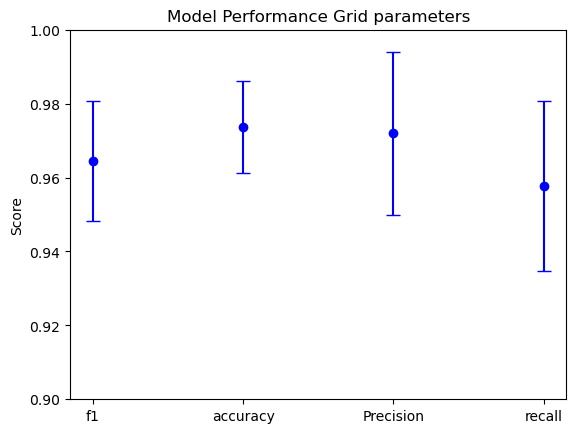

In [10]:
MLP_grid(X_train, X_test, y_train, y_test, X, y)

## Implementation of MLP_BO
I have used [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html) from scikit-learn to implement the Bayesian optimization on hyperparameters of the [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to get best hyperparameters that give best accuracy on the data.

In [11]:
def MLP_BO(X_train, X_test, y_train, y_test, X, y):
    # MLP classifier
    mlp = MLPClassifier(max_iter = 128, early_stopping = True, random_state = 2,
                        validation_fraction=0.2, n_iter_no_change=10)
    # Define the search space for the hyperparameters
    search_space = {
    'hidden_layer_sizes': Integer(32, 128, 'log-uniform'),
    'activation': Categorical(['relu', 'tanh','logistic']),
    'solver': Categorical(['adam', 'sgd']),
    'alpha': Real(1e-4, 1e-1, 'log-uniform'),
    'learning_rate': Categorical(['constant', 'invscaling', 'adaptive']),
    'learning_rate_init': Real(1e-4, 1e-1, 'log-uniform'),
    'batch_size': Integer(16, 64,'log-uniform'),
    }
    
    # Perform Bayesian Optimization to find the best hyperparameters
    optimizer = BayesSearchCV(mlp, search_space, cv=5, n_jobs=-1, scoring='accuracy')

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        optimizer.fit(X_train, y_train)
    
    # Print the best set of hyperparameters and the validation accuracy achieved with them
    print("Best set of hyperparameters:", optimizer.best_params_)
    print('Test accuracy of best model:', optimizer.score(X_test,y_test))
    
    
    clf = MLPClassifier( **optimizer.best_params_, random_state = 2, early_stopping = True, 
                        validation_fraction=0.2, n_iter_no_change=10)
    from sklearn.model_selection import cross_val_score
    scores1 = cross_val_score(clf, X, y, cv=5, scoring = 'f1')
    scores2 = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
    scores3 = cross_val_score(clf, X, y, cv=5, scoring = 'precision')
    scores4 = cross_val_score(clf, X, y, cv=5, scoring = 'recall')
    
    from prettytable import PrettyTable
 
    # These 3 are the columns of the tables
    t = PrettyTable(['performance factor', 'Mean', 'Standard Deviation +/-'])
 
    # To insert rows:
    t.add_row(['f1 score', round(scores1.mean(), 4), round(scores1.std(), 4)])
    t.add_row(['Accuracy', round(scores2.mean(), 4), round(scores2.std(), 4)])
    t.add_row(['Precision', round(scores3.mean(), 4), round(scores3.std(), 4)])
    t.add_row(['Recall', round(scores4.mean(), 4), round(scores4.std(), 4)])
 
    print(t)
    
    fig, ax = plt.subplots()
    ax.errorbar(['f1', 'accuracy', 'Precision', 'recall'], [scores1.mean(), scores2.mean(), scores3.mean(), scores4.mean()], 
           yerr = [scores1.std(), scores2.std(), scores3.std(), scores4.std()], fmt = 'o', capsize = 5, color = 'blue')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Bayesian Optimization')
    ax.set_ylim([0.9, 1])
    plt.show()

C:\Users\Will\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Will\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Will\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best set of hyperparameters: OrderedDict([('activation', 'tanh'), ('alpha', 0.07283999852199001), ('batch_size', 16), ('hidden_layer_sizes', 128), ('learning_rate', 'constant'), ('learning_rate_init', 0.1), ('solver', 'sgd')])
Test accuracy of best model: 0.9574468085106383
+--------------------+--------+------------------------+
| performance factor |  Mean  | Standard Deviation +/- |
+--------------------+--------+------------------------+
|      f1 score      |  0.96  |         0.0117         |
|      Accuracy      | 0.9701 |         0.0089         |
|     Precision      | 0.9586 |         0.0251         |
|       Recall       | 0.9625 |         0.0237         |
+--------------------+--------+------------------------+


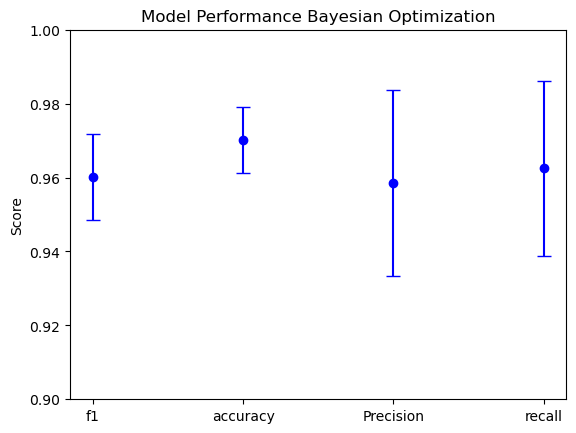

In [12]:
MLP_BO(X_train, X_test, y_train, y_test, X, y)

## Implementation of MLP_Funnel
I have used [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from scikit-learn to implement the grid search on hyperparameters of the [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) to get best hyperparameters that give best accuracy on the data. Here I did grid search on the funnel shapes multilayer perceptrons.

In [13]:
def MLP_Funnel(X_train, X_test, y_train, y_test, X, y):
    # MLP classifier
    mlp = MLPClassifier(max_iter = 128, random_state = 2, early_stopping = True, 
                        validation_fraction=0.2, n_iter_no_change=10)
    # Define the hyperparameters to search over (32, 16, 8) overfitting when used cross_validation
    param_grid = {
    'hidden_layer_sizes': [(128,64,32), (64,32,32,16),(32,32,16), (64, 64, 32, 16)],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'batch_size': [32, 64, 128],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    }
    
    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1,scoring='accuracy')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        grid_search.fit(X_train, y_train)
    
    # Print the best hyperparameters and their score
    print("Best hyperparameters:", grid_search.best_params_)
    print('Test accuracy for the best model:', grid_search.score(X_test, y_test))
    
    clf = MLPClassifier(**grid_search.best_params_ , random_state = 2,early_stopping = True, validation_fraction=0.2, 
                        n_iter_no_change=10)
    from sklearn.model_selection import cross_val_score
    scores1 = cross_val_score(clf, X, y, cv=5, scoring = 'f1')
    scores2 = cross_val_score(clf, X, y, cv=5, scoring = 'accuracy')
    scores3 = cross_val_score(clf, X, y, cv=5, scoring = 'precision')
    scores4 = cross_val_score(clf, X, y, cv=5, scoring = 'recall')
    
    from prettytable import PrettyTable
 
    # These 3 are the columns of the tables
    t = PrettyTable(['performance factor', 'Mean', 'Standard Deviation +/-'])
 
    # To insert rows:
    t.add_row(['f1 score', round(scores1.mean(), 4), round(scores1.std(), 4)])
    t.add_row(['Accuracy', round(scores2.mean(), 4), round(scores2.std(), 4)])
    t.add_row(['Precision', round(scores3.mean(), 4), round(scores3.std(), 4)])
    t.add_row(['Recall', round(scores4.mean(), 4), round(scores4.std(), 4)])
 
    print(t)
    
    fig, ax = plt.subplots()
    ax.errorbar(['f1', 'accuracy', 'Precision', 'recall'], [scores1.mean(), scores2.mean(), scores3.mean(), scores4.mean()], 
           yerr = [scores1.std(), scores2.std(), scores3.std(), scores4.std()], fmt = 'o', capsize = 5, color = 'blue')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Grid parameters')
    ax.set_ylim([0.9, 1])
    plt.show()
   

Best hyperparameters: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 32, 'hidden_layer_sizes': (32, 32, 16), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'solver': 'sgd'}
Test accuracy for the best model: 0.9574468085106383
+--------------------+--------+------------------------+
| performance factor |  Mean  | Standard Deviation +/- |
+--------------------+--------+------------------------+
|      f1 score      | 0.9428 |         0.0125         |
|      Accuracy      | 0.9578 |         0.0102         |
|     Precision      | 0.9578 |          0.03          |
|       Recall       | 0.9291 |         0.0154         |
+--------------------+--------+------------------------+


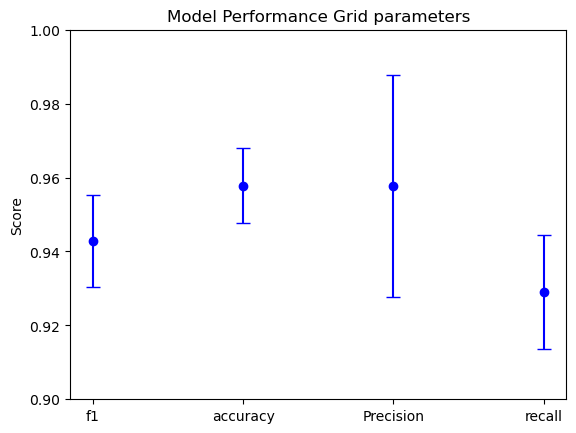

In [14]:
MLP_Funnel(X_train, X_test, y_train, y_test, X, y)

In [15]:
# Split data as train and test using train_test_split
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, y, test_size=0.33, random_state=128)

Best hyperparameters: {'activation': 'relu', 'alpha': 0.001, 'batch_size': 32, 'hidden_layer_sizes': (32,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'solver': 'sgd'}
Test accuracy for the best model: 0.9308510638297872
+--------------------+--------+------------------------+
| performance factor |  Mean  | Standard Deviation +/- |
+--------------------+--------+------------------------+
|      f1 score      | 0.9482 |         0.0137         |
|      Accuracy      | 0.9614 |         0.0105         |
|     Precision      | 0.9492 |         0.0267         |
|       Recall       | 0.9483 |         0.0273         |
+--------------------+--------+------------------------+


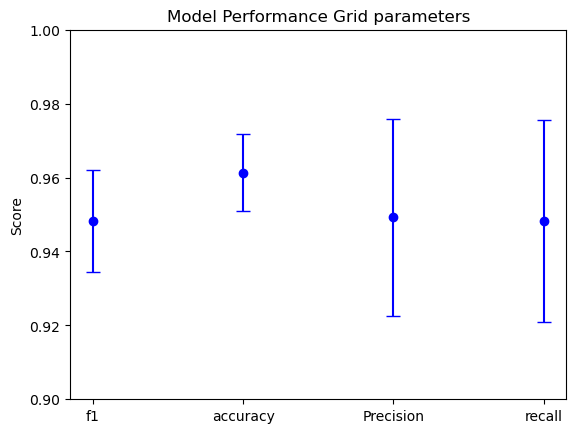

In [16]:
MLP_grid(X_train_svd, X_test_svd, y_train_svd, y_test_svd, X_svd, y)

C:\Users\Will\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Best set of hyperparameters: OrderedDict([('activation', 'tanh'), ('alpha', 0.0001), ('batch_size', 16), ('hidden_layer_sizes', 37), ('learning_rate', 'constant'), ('learning_rate_init', 0.1), ('solver', 'sgd')])
Test accuracy of best model: 0.973404255319149
+--------------------+--------+------------------------+
| performance factor |  Mean  | Standard Deviation +/- |
+--------------------+--------+------------------------+
|      f1 score      | 0.959  |         0.0098         |
|      Accuracy      | 0.9701 |         0.007          |
|     Precision      | 0.9809 |         0.0175         |
|       Recall       | 0.9385 |         0.0194         |
+--------------------+--------+------------------------+


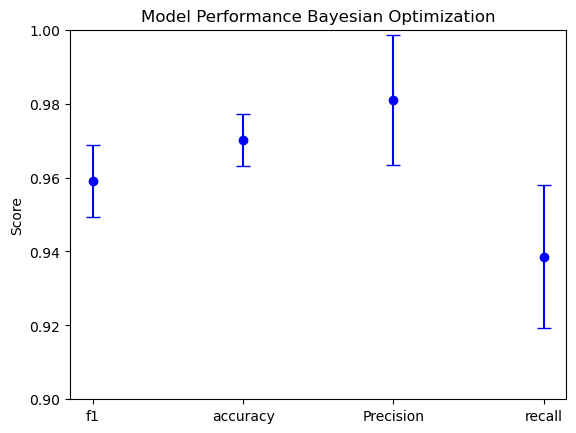

In [18]:
MLP_BO(X_train_svd, X_test_svd, y_train_svd, y_test_svd, X_svd, y)

**References**
1. [Scikit-learn hyperparameter optimization for MLPClassifier](https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b)
2. [Bayesian Optimization](https://www.kaggle.com/code/plbalmeida/task-1-classifier-bayesian-optimization/notebook)
3. [Cross Validation](https://stackabuse.com/cross-validation-and-grid-search-for-model-selection-in-python/)
4. [gid_search](https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-cross-validation-and-hyperparameter-tuning-using-gridsearch#:~:text=sklearn%20provides%20cross_val_score%20method%20which%20tries%20various%20combinations,score%20time%20and%20test%20scores%20for%20each%20splits.)